# Downloads & Import

In [40]:
from sklearn.metrics import f1_score
import numpy as np
import scipy.sparse as sp
import pandas as pd
# import networkx as nx
from typing import List , Dict,Tuple
import torch
import json

import torch_geometric.nn as  gnn

import matplotlib.pyplot as plt
import torch
import time
import numpy as np
import random
from tqdm.notebook import tqdm

generator = torch.manual_seed(232)
np.random.seed(232)
torch.cuda.manual_seed(232)
torch.cuda.manual_seed_all(232)
random.seed(232)

%run "../src/train_test_confidence.py"

In [18]:
config['graphs']['graph_path']

'../../data/graphs/graphs_sigma_us_equities_std_label'

In [2]:
"""
checkpoint model
"""
with open("../config_files/sage_sigma_titles_lstm_close_normal_target.json", 'r') as file:
    config = json.load(file)


model = torch.load(config["gnn_model"]["best_model_save_path"])
all_points = []
dataset = DayGraphs(config['graphs']['graph_path'])
for k in range(len(dataset)):
    all_points.append(dataset[k])

train_loader = GraphDataLoader(
        all_points[config['gnn_model']["start_day"]:config['gnn_model']["start_day"]+config['gnn_model']["train_size"]],
        batch_size=1, shuffle=False)
test_loader = GraphDataLoader(
    all_points[config['gnn_model']["start_day"]+config['gnn_model']["train_size"]:config['gnn_model']["start_day"]+config['gnn_model']["train_size"]+config['gnn_model']["test_interval"]],
    batch_size=1, shuffle=False)

def get_output(neurostock, data_loader, target_name="target"):

  neurostock.eval()
  device = next(neurostock.parameters()).device
  valid_losses = []
  # continue
  valid_outs = []
  valid_targets = []
  with torch.no_grad():
      for i, batch  in enumerate(data_loader):
        # if i > 2: break
        batch = batch.to(device)
        out = neurostock(batch)
        # print(out.squeeze(-1).unsqueeze(0))
        # print(batch["target"].shape)
        # break
        valid_outs.append(out.unsqueeze(0).cpu().detach())
        valid_targets.append(batch[target_name].unsqueeze(0).cpu().detach())
        loss = neurostock.compute_loss(out, batch[target_name])
        valid_losses.append(loss.item())
  valid_outs = torch.cat(valid_outs).numpy()
  valid_targets = torch.cat(valid_targets).numpy()
  return valid_outs, valid_targets

valid_outs, targets = get_output(model, test_loader, "target")

#### getting avg accuracy per company

<Axes: >

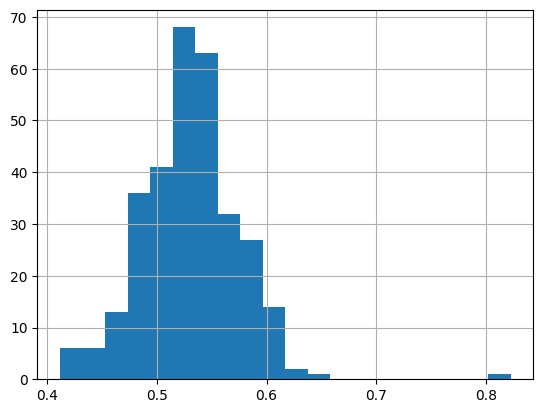

In [23]:
avg_acc_per_company = np.mean(valid_outs.argmax(-1)==targets, axis=0)
pd.Series(avg_acc_per_company).hist(bins=20)

#### analyzing accuracy for most mentioned companies

In [24]:

mentioned_companies = []
for batch in train_loader:
    mentioned_companies.append(batch["article", "main_company", "company"].edge_index[1])
most_mentioned = pd.Series(torch.cat(mentioned_companies)).value_counts()


In [34]:
print("mean high acc companies mentions",np.mean([ most_mentioned[k] for k in avg_acc_per_company.argsort()[-50:] if k in most_mentioned.index]))
print("median high acc companies mentions",np.median([ most_mentioned[k] for k in avg_acc_per_company.argsort()[-50:] if k in most_mentioned.index]))

mean high acc companies mentions 3846.469387755102
median high acc companies mentions 807.0


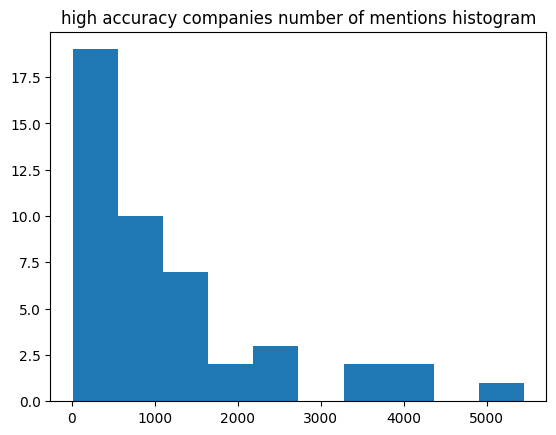

In [39]:
plt.title("high accuracy companies number of mentions histogram")
plt.hist([ most_mentioned[k] for k in avg_acc_per_company.argsort()[-50:] if k in most_mentioned.index and most_mentioned[k] < 10000])
plt.show()

In [36]:
print("mean low acc companies mentions", np.mean([ most_mentioned[k] for k in avg_acc_per_company.argsort()[:50] if k in most_mentioned.index]))
print("median low acc companies mentions", np.median([ most_mentioned[k] for k in avg_acc_per_company.argsort()[:50] if k in most_mentioned.index]))

mean low acc companies mentions 759.8125
median low acc companies mentions 302.5


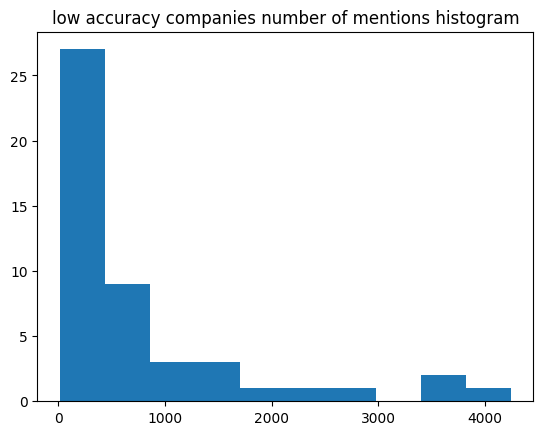

In [38]:
plt.title("low accuracy companies number of mentions histogram")
plt.hist([ most_mentioned[k] for k in avg_acc_per_company.argsort()[:50] if k in most_mentioned.index and most_mentioned[k] < 10000])
plt.show()

#### f1 score

In [47]:
f1_score(targets.reshape(-1),  valid_outs.argmax(-1).reshape(-1))


0.6406982473428592

#### companies with the highes accuracies

In [41]:
news_df = pd.read_csv("../../data/trained_files/processed_news_df.csv")
company_to_index = {k :v for v,k in zip(range(news_df["symbol"].nunique()), news_df["symbol"].unique()) }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse


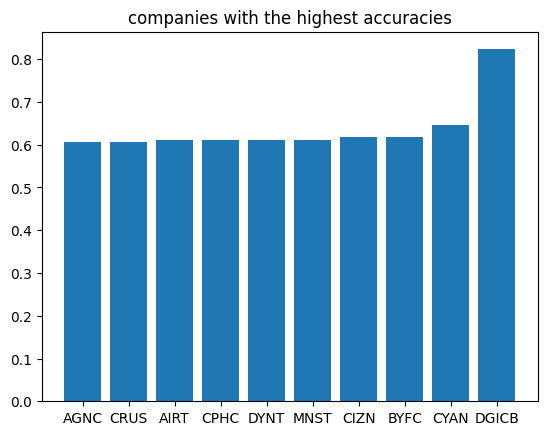

In [46]:
plt.title("companies with the highest accuracies")
plt.bar([index_to_company[company_index] for company_index in avg_acc_per_company.argsort()[-10:]],avg_acc_per_company[avg_acc_per_company.argsort()[-10:]])
plt.show()